# Final Analysis Results

In [194]:
import glob
import ipdb
import pickle as pkl
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [195]:
ls ../../results_inference

detfull_encoder_task_graph/  VAE.KL.0.0/  VAE.KL.0.001/  VAE.KL.1.0/


In [196]:
import pickle as pkl
with open('../../results_inference/VAE.KL.0.001/logs_episode.108_iter.0.pik_result.pkl', 'rb') as f:
    cont = pkl.load(f)

In [197]:
cont['length'].shape

()

In [198]:
cont.keys()

dict_keys(['results_total', 'results_total_tstep', 'gt_task', 'inp_task', 'pred_task', 'length'])

In [199]:
cont['length']

array(31., dtype=float32)

In [200]:
compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])

({'gt_task': array([[[0, 0, 0, ..., 0, 1, 0],
          [0, 0, 0, ..., 0, 1, 0],
          [0, 0, 0, ..., 0, 1, 0],
          ...,
          [0, 0, 0, ..., 0, 1, 0],
          [0, 0, 0, ..., 0, 1, 0],
          [0, 0, 0, ..., 0, 1, 0]]]),
  'mean_accuracy': array([0.43035191]),
  'mean_recall': array([0.51738584]),
  'mean_precision': array([0.82151451]),
  'mean_std': array([0.02895857]),
  'recall_tsteps': array([[0.15584416],
         [0.25541126],
         [0.38528139],
         [0.53679654],
         [0.46103896],
         [0.58441558],
         [0.63636364],
         [0.73160173],
         [0.69264069],
         [0.75324675]]),
  'accuracy_tsteps': array([[0.22727273],
         [0.28787879],
         [0.34848485],
         [0.42424242],
         [0.38636364],
         [0.43939394],
         [0.52272727],
         [0.59090909],
         [0.5       ],
         [0.59090909]]),
  'precision_tsteps': array([[0.55844156],
         [0.59112554],
         [0.7984127 ],
         [0.793661

In [201]:
def get_files(file_path, use_posterior=False):
    if use_posterior:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' in file]
    else:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' not in file]
    return files

In [ ]:
def bin_data(content, nbins=10, debug=False):
    # put data in nbins according to episode length
    res = content['results_total_tstep']['accuracy_pos_seed']
    nseeds = res.shape[0]
    length = content['length']
    bin_data = np.zeros((nbins, nseeds))
    
    tsteps_per_bin = length/nbins
    
    for i in range(nbins):
        ind1 = round(i * tsteps_per_bin)
        ind2 = round((i+1)*tsteps_per_bin)
        bin_data[i] = res[:, ind1:ind2, ...].mean(1)
    bin_data_mean = bin_data.mean(-1)
    bin_data_max = bin_data.max(-1)
    bin_data_std = bin_data.std(-1) / np.sqrt(11)
    return bin_data_mean, bin_data_std, bin_data_max

In [8]:
def get_info_episodes(exp_name):
    print(f"Loading {exp_name}")
    file_path = f'../../results_inference/{exp_name}'
    files_interest = get_files(file_path)
    all_mean, all_se, all_max = [], [], []
    for cfile_name in files_interest:
        with open(cfile_name, 'rb') as f:
            cont = pkl.load(f)
        b_mean, b_se, b_max = bin_data(cont)
        
        all_mean.append(b_mean[None, :])
        all_se.append(b_se[None, :])
        all_max.append(b_max[None, :])
    all_mean = np.concatenate(all_mean, 0)
    all_max = np.concatenate(all_max, 0)
    all_se = np.concatenate(all_se, 0)
    return all_mean, all_se, all_max

In [ ]:
names = [x.split('/')[-1] for x in glob.glob('../../results_inference/*')]
print(names)
plt.figure()
ax = plt.gca()
for name_exp in names:
#     color=next(ax._get_lines.color_cycle)
    color=next(ax._get_lines.prop_cycler)['color']
    print(color)
    all_mean, all_se, all_max = get_info_episodes(name_exp)
    x = np.arange(10)
    mean_return = all_mean.mean(0)
    mean_se = all_se.mean(0)
    ymin = mean_return - mean_se
    ymax = mean_return + mean_se
    plt.plot(x, mean_return, label=name_exp, color=color)
    plt.plot(x, all_max.mean(0), '--', color=color)
    plt.fill_between(x, ymin, ymax, alpha=0.2, color=color)

plt.ylabel("Accuracy of changing preds")
plt.xlabel("Time step")
plt.grid()
plt.legend()

In [ ]:
all_mean.shape

# Recall

In [8]:
def get_files(file_path, use_posterior=False):
    if use_posterior:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' in file]
    else:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' not in file]
    return files

In [9]:
import ipdb
eps = 1e-9
def compute_tsteps(metric, len_mask, nbins=10):
    
    # Put metrics in timesteps
    nseeds = metric.shape[0]
    length = len_mask.sum(-1)
    norm_mask = len_mask / len_mask.sum(-1)[..., None]
    tsteps_per_bin = length/nbins
    bin_data = np.zeros((nbins, nseeds))
    
    mean = (metric * norm_mask).sum(-1)
    for i in range(nbins):
        ind1 = round(i * tsteps_per_bin)
        ind2 = round((i+1)*tsteps_per_bin)
        bin_data[i] = metric[:, ind1:ind2, ...].mean(1)
    return mean, bin_data

def compute_metrics(pred_task, gt_task, length, nbins=10, debug=False):
    gt_task = gt_task[None, ...]
    length = int(length)
    T = pred_task.shape[1]
    gt_task_d = gt_task[None, ...]
    len_mask = np.zeros(T)
    len_mask[:length] = 1
    
    gt_p = gt_task / gt_task.sum(-1)[..., None]
    pos_gt_p = (gt_task > 0) / ((gt_task > 0).sum(-1)[..., None] + eps)
    pred_p = (pred_task > 0) / ((pred_task > 0).sum(-1)[..., None] + eps)
    
    accuracy = (((gt_task == pred_task) * pos_gt_p).sum(-1)).mean(0)[None, ...]
    recall = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).mean(0)[None, ...]
    prec = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).mean(0)[None, ...]
    
    accuracymax = (((gt_task == pred_task) * pos_gt_p).sum(-1)).max(0)[None, ...]
    recallmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).max(0)[None, ...]
    precmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).max(0)[None, ...]
    
    
    max_gt_pred = gt_task.max(-1)
#     ipdb.set_trace()
    std = np.std(pred_task, axis=0).mean(-1)[None, ...]
    
#     ipdb.set_trace()
    m_ac, t_ac = compute_tsteps(accuracy, len_mask, nbins)
    m_rec, t_rec = compute_tsteps(recall, len_mask, nbins)
    m_prec, t_prec = compute_tsteps(prec, len_mask, nbins)
    m_std, t_std = compute_tsteps(std, len_mask, nbins)
    
    m_acm, t_acm = compute_tsteps(accuracymax, len_mask, nbins)
    m_recm, t_recm = compute_tsteps(recallmax, len_mask, nbins)
    m_precm, t_precm = compute_tsteps(precmax, len_mask, nbins)
    if debug:
        ipdb.set_trace()
    dict_res = {
        'gt_task': gt_task,
        'mean_accuracy': m_ac,
        'mean_recall': m_rec,
        'mean_precision': m_prec,
        'mean_std': m_std,
        'recall_tsteps': t_rec,
        'accuracy_tsteps': t_ac,
        'precision_tsteps': t_prec,
        'std_tsteps': t_std,
        'recallmax_tsteps': t_recm,
        'accuracymax_tsteps': t_acm,
        'precisionmax_tsteps': t_precm,
        'std_tsteps': t_std
    }
    return dict_res

def get_random(size):
    # returns a tensor of size [size, 136] with random samples
    max_vec = ("0 0 0 2 0 5 0 3 0 0 2 0 0 0 1 0 0 0 0 0 "
               "0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 "
               "0 0 0 0 0 0 0 2 0 7 0 2 0 0 2 0 0 0 3 7 "
               "0 0 3 0 0 0 0 0 0 3 7 0 0 3 0 0 0 0 0 0 "
               "2 0 6 0 3 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 "
               "0 0 2 0 7 0 3 0 0 2 0 0 0 2 6 0 0 3 0 0 "
               "0 0 0 0 3 6 0 0 3 0 0 0 0 0 1 1")
    max_vec = np.array([int(x) for x in max_vec.split()])
    new_size = list(size)+[max_vec.shape[0]]
    res = np.random.rand(*new_size)
    
    res *= max_vec
    res = res.astype(np.int32)
    return res

def get_info_episodes_new(exp_name, rand_uniform=False):
    print(f"Loading {exp_name}")
    file_path = f'../../results_inference/{exp_name}'
    files_interest = get_files(file_path)
    all_results = {}
    for cfile_name in files_interest:
        with open(cfile_name, 'rb') as f:
            cont = pkl.load(f)
        if type(cont) == list:
            continue
        if not rand_uniform:
            results = compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])
        else:
            random_vec = get_random(cont['pred_task'].shape[:-1])
            results = compute_metrics(random_vec, cont['gt_task'], cont['length'], debug=False)
            
        for name_res, res_val in results.items():
            if name_res not in all_results:
                all_results[name_res] = [res_val[None, ...]]
            else:
                all_results[name_res].append(res_val[None, ...])
    aggregated_results = {}
    aggregated_results['names'] = list(all_results.keys())
    for res_name, res_val in all_results.items():
        res_val = np.concatenate(res_val, 0)
        if res_name == 'gt_task':
            continue
        all_results_mean = res_val.mean(0)
        all_results_std = res_val.std(0) / np.sqrt(res_val.shape[0])

        aggregated_results[f'{res_name}_mean'] = all_results_mean.mean(-1)
        aggregated_results[f'{res_name}_std'] = all_results_std .mean(-1)
    return aggregated_results

In [10]:
original_name_exp = '../../results_inference/detfull_encoder_task_graph/logs_episode.534_iter.0.pik_result.pkl'

with open(original_name_exp, 'rb') as f:
    cont = pkl.load(f)
results = compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])
results['accuracy_tsteps'][0]

array([0.15909091])

In [34]:
original_name_exp = '../../results_inference/VAE.KL.0.001/logs_episode.534_iter.0.pik_result.pkl'

with open(original_name_exp, 'rb') as f:
    cont = pkl.load(f)
results = compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])
results['accuracy_tsteps'][0]

array([0.23863636])

In [12]:
results['accuracy_tsteps'][0]

array([0.23863636])

Loading VAE.KL.0.001
Loading detfull_encoder_task_graph
Loading VAE.KL.1.0
Loading VAE.KL.0.0
Loading VAE.KL.0.0


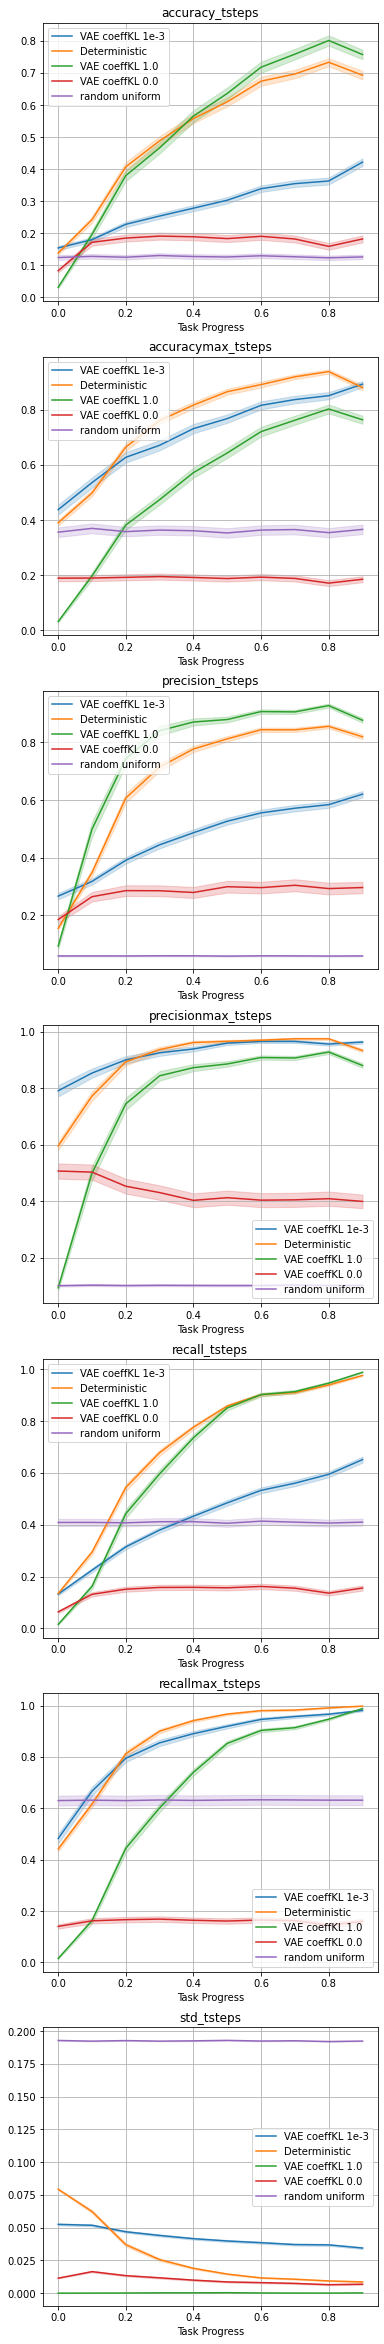

In [13]:
names_exp = [x.split('/')[-1] for x in glob.glob('../../results_inference/*')]
names_exp.append(names_exp[-1])
# print(names)
ax_plots = None

ax = plt.gca()
colors=[next(ax._get_lines.prop_cycler)['color'] for _ in range(len(names_exp))]
plt.close()
name_dict = {
    'VAE.KL.0.0': 'VAE coeffKL 0.0',
    'VAE.KL.1.0': 'VAE coeffKL 1.0',
    'VAE.KL.0.001': 'VAE coeffKL 1e-3',
    'detfull_encoder_task_graph': 'Deterministic',
    'random uniform': 'random uniform'
}
for index_exp, name_exp in enumerate(names_exp):
    original_name_exp = name_exp
    if index_exp == (len(names_exp) - 1):
        name_exp = 'random uniform'
        rand = True
    else:
        rand = False
    color = colors[index_exp]
#     name_exp = 
    final_res = get_info_episodes_new(original_name_exp, rand)
    if ax_plots is None:
        names = sorted([name for name in final_res['names'] if 'steps' in name])
        fig, ax_plots = plt.subplots(len(names), 1, figsize=(6, 6*len(names)))

#     if rand:
#         ipdb.set_trace()
    for index, name_metric in enumerate(names):
#         color=colors[index_exp]
        curr_ax = ax_plots[index]
        x = np.arange(10)*1/10
#         print(name_metric, x.shape, mean_return.shape)
        mean_return = final_res[name_metric+'_mean']
        mean_se = final_res[name_metric+'_std']
#         mean_se = all_se.mean(0)
        ymin = mean_return - mean_se
        ymax = mean_return + mean_se
        curr_ax.plot(x, mean_return, label=name_dict[name_exp], color=color)
#         curr_ax.plot(x, all_max.mean(0), '--', color=color)
        curr_ax.fill_between(x, ymin, ymax, alpha=0.2, color=color)
for ind, ax in enumerate(ax_plots):
    ax.legend()
    ax.set_title(names[ind])
    ax.grid()
    ax.set_xlabel("Task Progress")

# Debug

In [11]:
# Check differences in recall

In [44]:
names_exp

['VAE.KL.0.001', 'detfull_encoder_task_graph', 'VAE.KL.1.0', 'VAE.KL.0.0']

In [217]:
eps = 1e-9
names_exp = [x.split('/')[-1] for x in glob.glob('../../results_inference/*')]
deterministic = names_exp[1]
# final_res = get_info_episodes_new(deterministic, rand)
def get_files(file_path, use_posterior=False):
    if use_posterior:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' in file]
    else:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' not in file]
    return files

def compute_tsteps(metric, len_mask, nbins=10, debug=False):
    
    # Put metrics in timesteps
    nseeds = metric.shape[0]
    length = len_mask.sum(-1)
    norm_mask = len_mask / len_mask.sum(-1)[..., None]
    
    if nbins == -1:
        nbins = int(length)
    tsteps_per_bin = length/nbins
    bin_data = np.zeros((nbins, nseeds))
    
    mean = (metric * norm_mask).sum(-1)
    for i in range(nbins):
        ind1 = round(i * tsteps_per_bin)
        ind2 = round((i+1)*tsteps_per_bin)
        if debug:
            print(ind1, ind2, metric[:, ind1:ind2, ...].mean(1))
        bin_data[i] = metric[:, ind1:ind2, ...].mean(1)
#     ipdb.set_trace()
    return mean, bin_data

def compute_metrics(pred_task, gt_task, length, nbins=10, debug=False):
    gt_task = gt_task[None, ...]
    length = int(length)
    T = pred_task.shape[1]
    gt_task_d = gt_task[None, ...]
    len_mask = np.zeros(T)
    len_mask[:length] = 1
    
    gt_p = gt_task / gt_task.sum(-1)[..., None]
    pos_gt_p = (gt_task > 0) / ((gt_task > 0).sum(-1)[..., None] + eps)
    pred_p = (pred_task > 0) / ((pred_task > 0).sum(-1)[..., None] + eps)
    
    accuracy = (((gt_task == pred_task) * pos_gt_p).sum(-1)).mean(0)[None, ...]
    recall = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).mean(0)[None, ...]
    prec = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).mean(0)[None, ...]
    
    accuracymax = (((gt_task == pred_task) * pos_gt_p).sum(-1)).max(0)[None, ...]
    recallmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).max(0)[None, ...]
    precmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).max(0)[None, ...]
    
    
    max_gt_pred = gt_task.max(-1)
#     ipdb.set_trace()
    std = np.std(pred_task, axis=0).mean(-1)[None, ...]
    
#     ipdb.set_trace()
#     print(recallmax[0])
#     print(recallmax)
    m_ac, t_ac = compute_tsteps(accuracy, len_mask, nbins)
    m_rec, t_rec = compute_tsteps(recall, len_mask, nbins)
    m_prec, t_prec = compute_tsteps(prec, len_mask, nbins)
    m_std, t_std = compute_tsteps(std, len_mask, nbins)
    
    m_acm, t_acm = compute_tsteps(accuracymax, len_mask, nbins)
    m_recm, t_recm = compute_tsteps(recallmax, len_mask, nbins)
    m_precm, t_precm = compute_tsteps(precmax, len_mask, nbins)
    if debug:
        ipdb.set_trace()
    dict_res = {
        'gt_task': gt_task,
        'mean_accuracy': m_ac,
        'mean_recall': m_rec,
        'mean_precision': m_prec,
        'mean_std': m_std,
        'recall_tsteps': t_rec,
        'accuracy_tsteps': t_ac,
        'precision_tsteps': t_prec,
        'std_tsteps': t_std,
        'recallmax_tsteps': t_recm,
        'accuracymax_tsteps': t_acm,
        'precisionmax_tsteps': t_precm,
        'std_tsteps': t_std
    }
    return dict_res

exp_name = deterministic
print(f"Loading {exp_name}")
file_path = f'../../results_inference/{exp_name}'
files_interest = get_files(file_path)
all_results = {}
i = 0
# for cfile_name in sorted(files_interest):
# #     if '534' not in cfile_name:
# #         continue
# #     if i == 0:
# #         i += 1
# #         continue
   
#     with open(cfile_name, 'rb') as f:
#         cont = pkl.load(f)
#     if type(cont) == list:
#         continue
#     results, rm = compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])
    
#     with open(cfile_name.replace(names_exp[1], names_exp[0]), 'rb') as f:
#         cont2 = pkl.load(f)
#     if type(cont2) == list:
#         continue
#     results2, rm2 = compute_metrics(cont2['pred_task'], cont2['gt_task'], cont2['length'])
    
#     m1 = results['recallmax_tsteps'].mean()
#     m2 = results2['recallmax_tsteps'].mean()
#     if m1 > m2:
#         print(results['recallmax_tsteps'])
#         print(results2['recallmax_tsteps'])
#         print(cfile_name)
#         ipdb.set_trace()

Loading detfull_encoder_task_graph


In [14]:
# Compute Lengths


In [30]:
lengths = []
exp_name = deterministic
print(f"Loading {exp_name}")
file_path = f'../../results_inference/{exp_name}'
files_interest = get_files(file_path)
for cfile_name in sorted(files_interest):
    with open(cfile_name, 'rb') as f:
        cont = pkl.load(f)
    if type(cont) == list:
        ipdb.set_trace()
    lengths.append((int(cont['length']), cfile_name))

Loading detfull_encoder_task_graph
> /tmp/ipykernel_30871/2420262630.py(11)<module>()
      9     if type(cont) == list:
     10         ipdb.set_trace()
---> 11     lengths.append((int(cont['length']), cfile_name))

ipdb> cfile_name
'../../results_inference/detfull_encoder_task_graph/pred_dict.pkl'
ipdb> exit


BdbQuit: 

(array([41., 82., 20., 29., 36., 41., 13., 14., 10.,  7.]),
 array([12., 16., 20., 24., 28., 32., 36., 40., 44., 48., 52.]),
 <BarContainer object of 10 artists>)

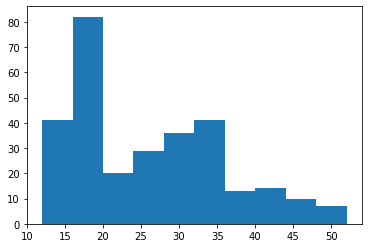

In [27]:
history = [x[0] for x in lengths]
plt.hist(history)

In [29]:
[x for x in lengths if x[0] > 40]

[(45,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.152_iter.0.pik_result.pkl'),
 (49,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.154_iter.0.pik_result.pkl'),
 (52,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.155_iter.0.pik_result.pkl'),
 (43,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.180_iter.0.pik_result.pkl'),
 (49,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.192_iter.0.pik_result.pkl'),
 (45,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.20_iter.0.pik_result.pkl'),
 (41,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.271_iter.0.pik_result.pkl'),
 (48,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.275_iter.0.pik_result.pkl'),
 (49,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.284_iter.0.pik_result.pkl'),
 (41,
  '../../results_inference/detfull_encoder_task_graph/logs_episode.294_iter.0

In [113]:
names_preds = '../../results_inference/detfull_encoder_task_graph/pred_dict.pkl'
with open(names_preds, 'rb') as f:
    name_preds = pkl.load(f)
    

In [135]:
name_preds_ind = [(i, x) for i, x in enumerate(name_preds)]
name_preds_ind = sorted(name_preds_ind, key=lambda x: (x[1][1], x[1][0]))
indices_sorted = np.array([ind[0] for ind in name_preds_ind])
# sort by container

[(132, ('character', 'bathroom')),
 (0, ('apple', 'bathroomcabinet')),
 (11, ('chips', 'bathroomcabinet')),
 (22, ('condimentbottle', 'bathroomcabinet')),
 (33, ('condimentshaker', 'bathroomcabinet')),
 (44, ('cupcake', 'bathroomcabinet')),
 (55, ('cutleryfork', 'bathroomcabinet')),
 (66, ('plate', 'bathroomcabinet')),
 (77, ('pudding', 'bathroomcabinet')),
 (88, ('remotecontrol', 'bathroomcabinet')),
 (99, ('salmon', 'bathroomcabinet')),
 (110, ('waterglass', 'bathroomcabinet')),
 (121, ('wineglass', 'bathroomcabinet')),
 (133, ('character', 'bedroom')),
 (1, ('apple', 'cabinet')),
 (12, ('chips', 'cabinet')),
 (23, ('condimentbottle', 'cabinet')),
 (34, ('condimentshaker', 'cabinet')),
 (45, ('cupcake', 'cabinet')),
 (56, ('cutleryfork', 'cabinet')),
 (67, ('plate', 'cabinet')),
 (78, ('pudding', 'cabinet')),
 (89, ('remotecontrol', 'cabinet')),
 (100, ('salmon', 'cabinet')),
 (111, ('waterglass', 'cabinet')),
 (122, ('wineglass', 'cabinet')),
 (2, ('apple', 'character')),
 (13, ('ch

In [183]:

def plot_predicates(episode_info):
    
    max_vec = ("0 0 0 2 0 5 0 3 0 0 2 0 0 0 1 0 0 0 0 0 "
           "0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 "
           "0 0 0 0 0 0 0 2 0 7 0 2 0 0 2 0 0 0 3 7 "
           "0 0 3 0 0 0 0 0 0 3 7 0 0 3 0 0 0 0 0 0 "
           "2 0 6 0 3 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 "
           "0 0 2 0 7 0 3 0 0 2 0 0 0 2 6 0 0 3 0 0 "
           "0 0 0 0 3 6 0 0 3 0 0 0 0 0 1 1")
    
    names_preds = '../../results_inference/detfull_encoder_task_graph/pred_dict.pkl'
    with open(names_preds, 'rb') as f:
        name_preds = pkl.load(f)
    
    # sort according to category
    max_vec = np.array([int(x) for x in max_vec.split()])[indices_sorted]
    name_preds = [name_preds[index] for index in indices_sorted]
    print(cont['gt_task'].shape)
    gt = cont['gt_task'][:, indices_sorted] 
    pred = cont['pred_task'][:, :, indices_sorted]
    inp = cont['inp_task'][:, indices_sorted]
    
    indices_greater_0 = np.where(max_vec > 0)[0]
    names_predicates = ['{}-{}'.format(n[0], n[1]) for n in name_preds]
    names_predicates = [names_predicates[ind] for ind in list(indices_greater_0)]
    length = int(cont['length'])
    npred = cont['pred_task'].shape[0]
    print(cont['pred_task'].shape)
    gt = gt[:length, indices_greater_0] 
    
    print(gt[:1, :][None, ...].shape)
    gt_single = np.tile(gt[:1, :][None, ...], (npred, 1, 1))
    
    pred = pred[:, :length, indices_greater_0]
    
    pred = np.concatenate([pred, gt_single], 1)
    fig, ax = plt.subplots(3, 4, figsize=(28,16))
    ax = np.reshape(ax, -1)
    
    
    for i in range(len(ax)):
        if i < pred.shape[0]:
            ax[i].matshow(pred[i].transpose(), vmin=0, vmax=5.)
        else:
            ax[i].matshow(inp[:length+1, indices_greater_0].transpose(), vmin=0., vmax=7.0)
            # ax[i].matshow(np.zeros(pred[0].transpose().shape))
    plt.set_cmap('hot')
    ct = 0
    num_rows = 4
    for axis in ax:
        if ct % num_rows == 0:
            axis.set_yticks([i for i in range(len(names_predicates))])
            axis.set_yticklabels(names_predicates)
        ct += 1

In [184]:
import pickle as pkl
with open('../../results_inference/detfull_encoder_task_graph/logs_episode.152_iter.0.pik_result.pkl', 'rb') as f:
    cont = pkl.load(f)

In [185]:
cont['inp_task'].shape

(74, 136)

(74, 136)
(11, 74, 136)
(1, 1, 33)


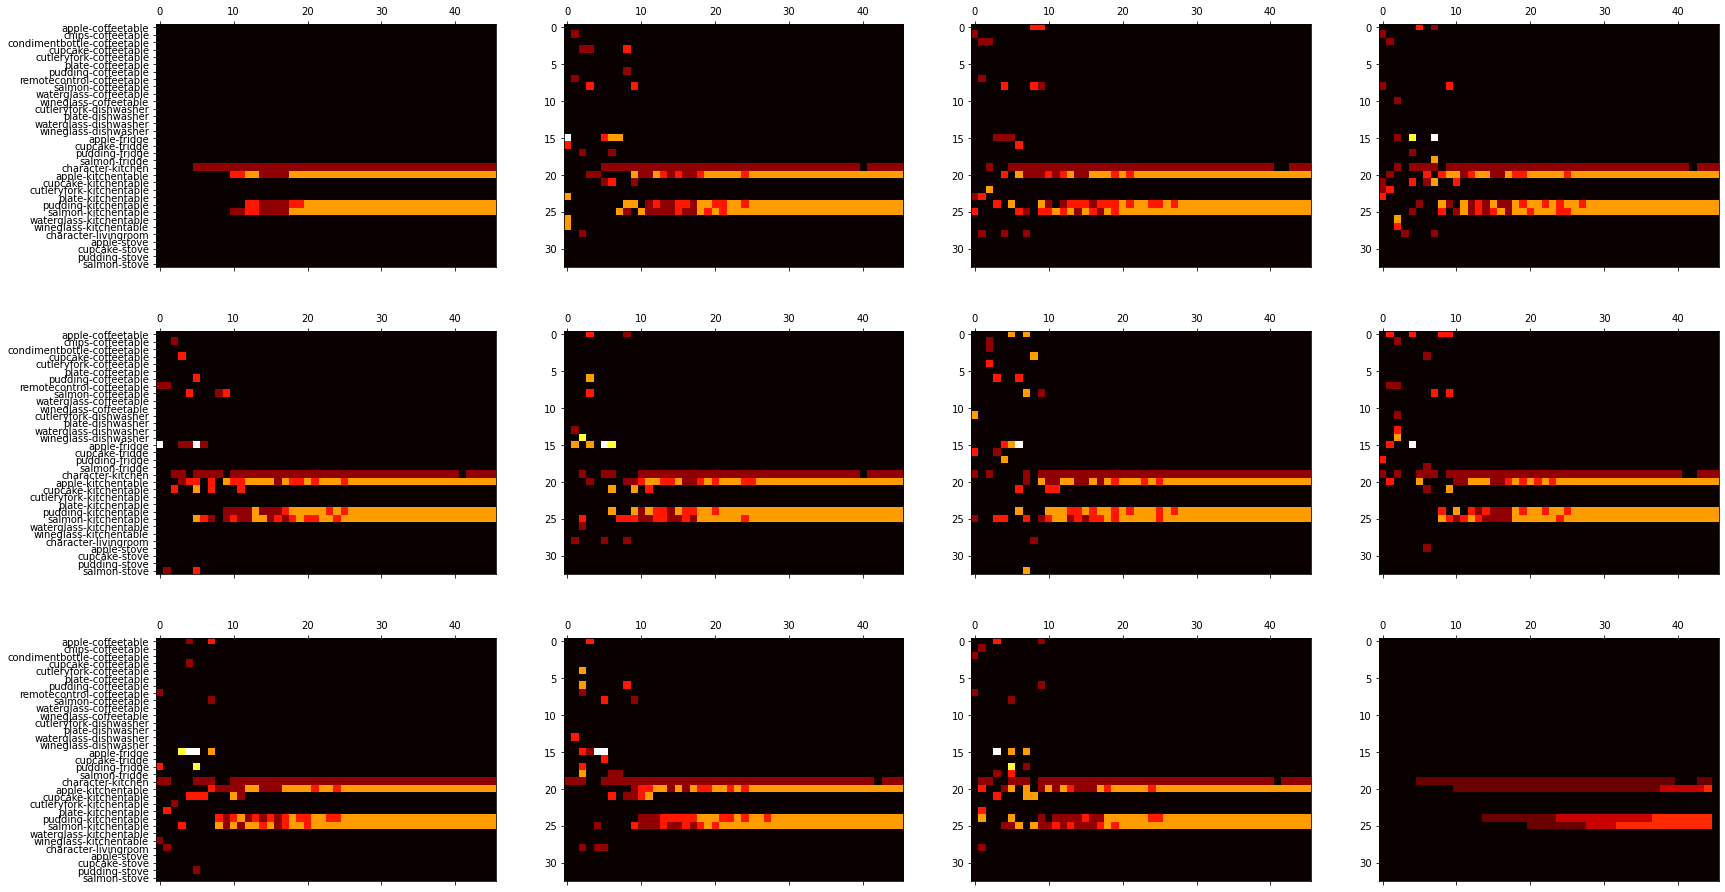

In [186]:
plot_predicates(cont)

In [189]:
import pickle as pkl
with open('../../results_inference/VAE.KL.0.001//logs_episode.152_iter.0.pik_result.pkl', 'rb') as f:
    cont = pkl.load(f)

(74, 136)
(11, 74, 136)
(1, 1, 33)


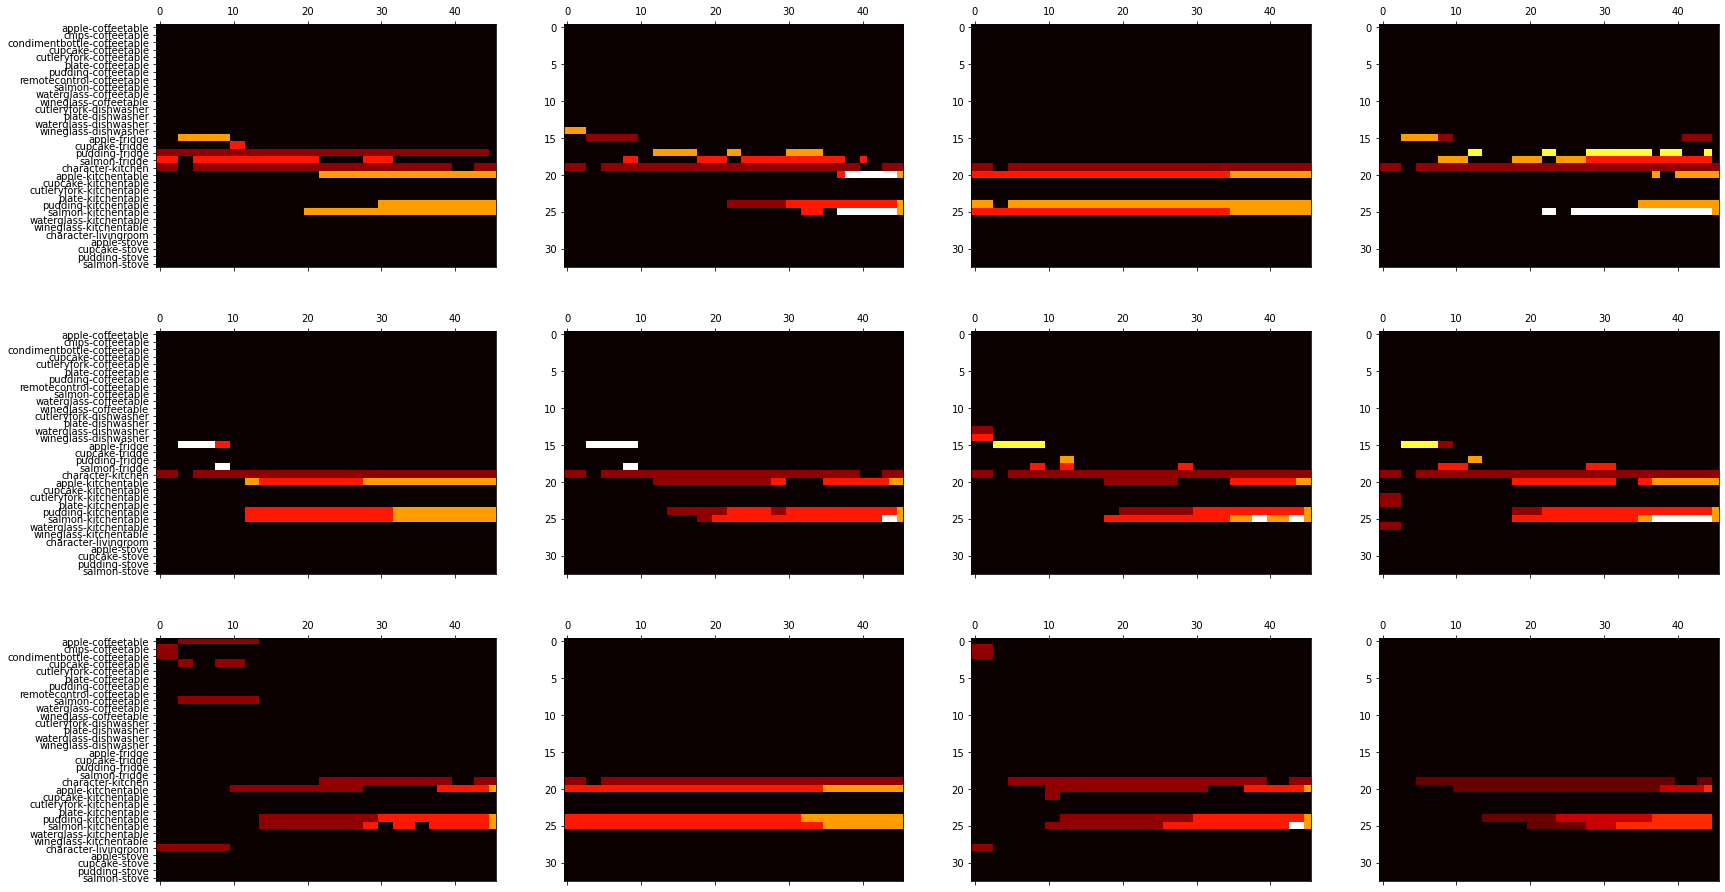

In [190]:
plot_predicates(cont)

In [162]:
cont['gt_task'][0]

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0])

In [139]:
cont['pred_task'].shape


(11, 74, 136)

In [11]:
import numpy as np
np.zeros((3,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [129]:
ls ../../results_inference

detfull_encoder_task_graph/  VAE.KL.0.0/  VAE.KL.0.001/  VAE.KL.1.0/


## Test single episode

In [280]:

def get_info_episodes_single(exp_name, rand_uniform=False):
    print(f"Loading {exp_name}")
    file_path = f'../../results_inference/{exp_name}'
    files_interest = get_files(file_path)
    all_results = {}
    for cfile_name in files_interest:
        if 'logs_episode.551_iter.0' not in cfile_name:
            continue
        print(cfile_name)
        with open(cfile_name, 'rb') as f:
            cont = pkl.load(f)
        if type(cont) == list:
            continue
        results = compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'], nbins=-1)
        for name_res, res_val in results.items():
            if name_res not in all_results:
                all_results[name_res] = [res_val[None, ...]]
            else:
                all_results[name_res].append(res_val[None, ...])
    aggregated_results = {}
    aggregated_results['names'] = list(all_results.keys())
    for res_name, res_val in all_results.items():
        res_val = np.concatenate(res_val, 0)
        if res_name == 'gt_task':
            continue
        all_results_mean = res_val.mean(0)
        all_results_std = res_val.std(0) / np.sqrt(res_val.shape[0])

        aggregated_results[f'{res_name}_mean'] = all_results_mean.mean(-1)
        aggregated_results[f'{res_name}_std'] = all_results_std .mean(-1)
    return aggregated_results

Loading VAE.KL.0.001
../../results_inference/VAE.KL.0.001/logs_episode.551_iter.0.pik_result.pkl


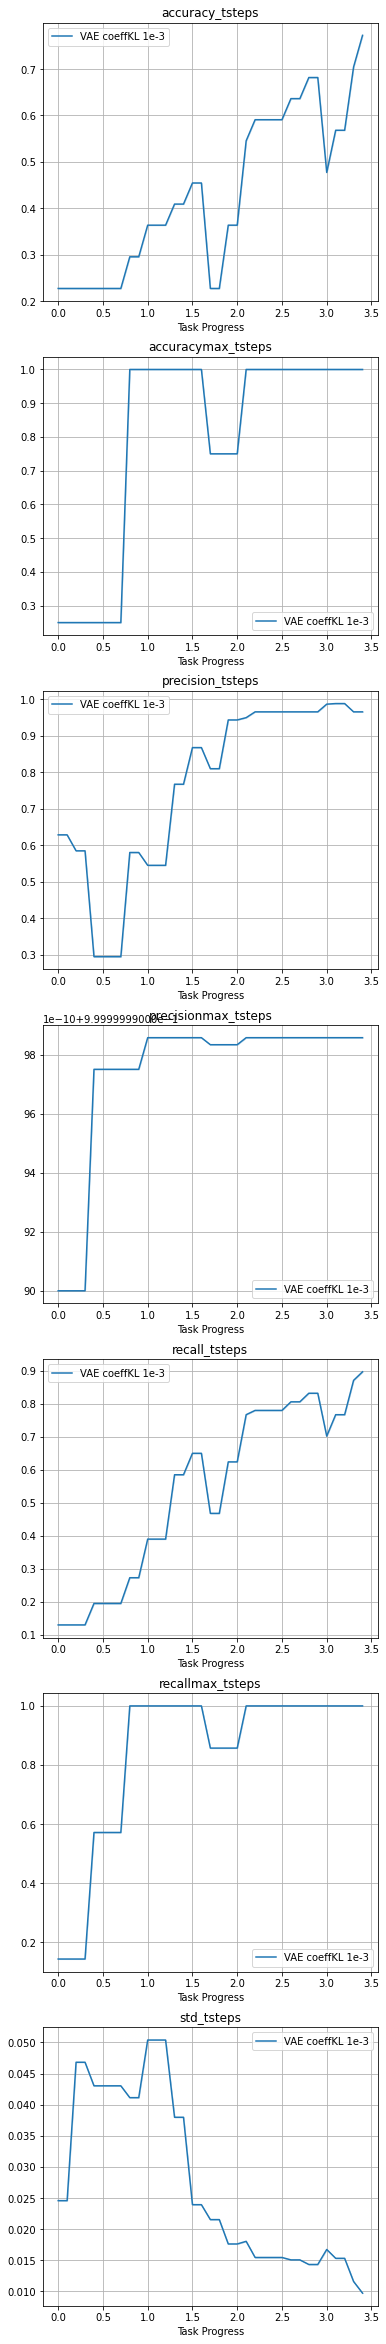

In [296]:


names_exp = [x.split('/')[-1] for x in glob.glob('../../results_inference/*')]
names_exp.append(names_exp[-1])
# print(names)
ax_plots = None

ax = plt.gca()
colors=[next(ax._get_lines.prop_cycler)['color'] for _ in range(len(names_exp))]
plt.close()
name_dict = {
    'VAE.KL.0.001': 'VAE coeffKL 1e-3'
}

for index_exp, name_exp in enumerate(names_exp):
    if name_exp not in name_dict:
        continue
    original_name_exp = name_exp
    if index_exp == (len(names_exp) - 1):
        name_exp = 'random uniform'
        rand = True
    else:
        rand = False
    color = colors[index_exp]
#     name_exp = 
    final_res = get_info_episodes_single(original_name_exp, rand)
    if ax_plots is None:
        names = sorted([name for name in final_res['names'] if 'steps' in name])
        fig, ax_plots = plt.subplots(len(names), 1, figsize=(6, 6*len(names)))

#     if rand:
#         ipdb.set_trace()
    for index, name_metric in enumerate(names):
#         color=colors[index_exp]
        curr_ax = ax_plots[index]
        nb = len(final_res[name_metric+'_mean'])
        x = np.arange(nb)*1/10
#         print(name_metric, x.shape, mean_return.shape)
        mean_return = final_res[name_metric+'_mean']
        mean_se = final_res[name_metric+'_std']
#         mean_se = all_se.mean(0)
        ymin = mean_return - mean_se
        ymax = mean_return + mean_se
        curr_ax.plot(x, mean_return, label=name_dict[name_exp], color=color)
#         curr_ax.plot(x, all_max.mean(0), '--', color=color)
        curr_ax.fill_between(x, ymin, ymax, alpha=0.2, color=color)
for ind, ax in enumerate(ax_plots):
    ax.legend()
    ax.set_title(names[ind])
    ax.grid()
    ax.set_xlabel("Task Progress")

In [261]:
ls ../../result_inference*

../../result_inference.pkl


In [360]:
ls -lt ../../result_inference.pkl

-rw-rw-r-- 1 xavierpuig vision-torralba 3900 Apr 25 19:40 ../../result_inference.pkl


In [373]:
with open('../../result_inference.pkl', 'rb') as f:
    cont = pkl.load(f)


In [374]:
names = cont['smart_reset'].keys()

In [375]:
cont['smart_reset']['recallmax']

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.42857143, 0.42857143, 0.42857143, 0.71428571, 0.71428571,
       0.71428571, 0.71428571, 0.71428571, 0.71428571, 0.71428571,
       0.71428571, 0.71428571, 0.71428571, 0.71428571, 0.71428571,
       0.71428571, 0.71428571, 0.71428571, 0.71428571, 0.71428571,
       0.71428571, 0.71428571, 0.71428571, 0.71428571])

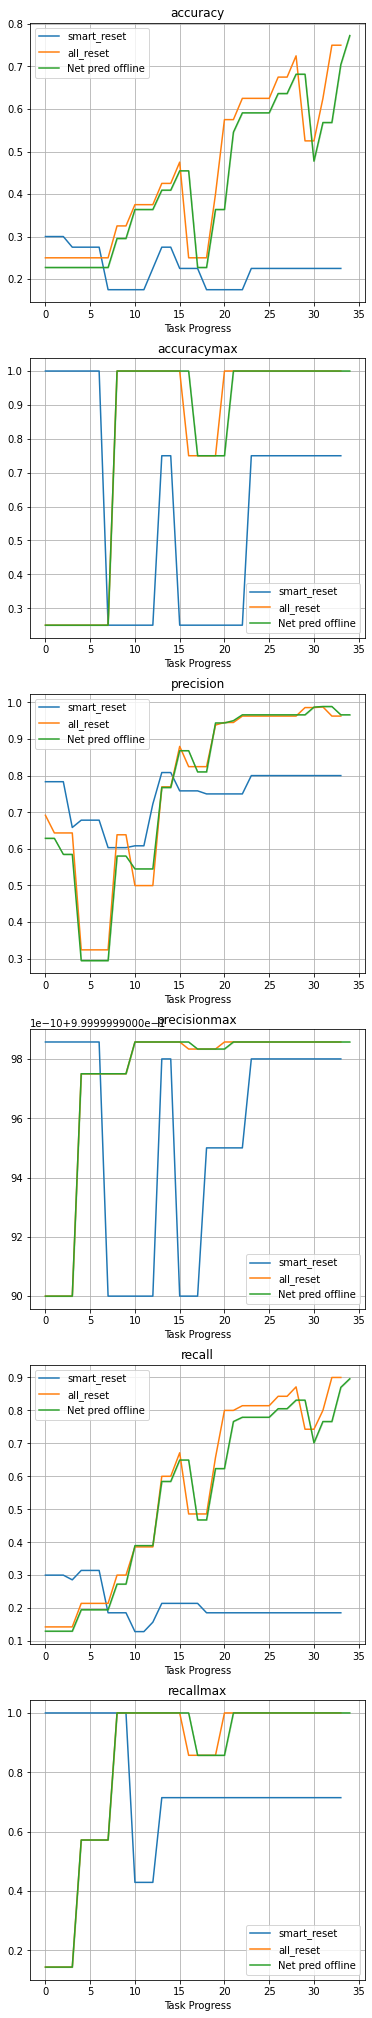

In [376]:
names = sorted([name for name in names])
fig, ax_plots = plt.subplots(len(names), 1, figsize=(6, 6*len(names)))
for i in range(3):
    color = colors[i]
    if i == 0:
        content = cont['smart_reset']
        cname = 'smart_reset'
    elif i == 1:
        content = cont['all_reset']
        cname = 'all_reset'
    if i < 2:
        for index, name_metric in enumerate(names):
        #         color=colors[index_exp]
            curr_ax = ax_plots[index]
            nb = len(content[name_metric])
            x = np.arange(nb)
        #         print(name_metric, x.shape, mean_return.shape)
            mean_return = content[name_metric]
            curr_ax.plot(x, mean_return, label=cname, color=color)
    else:
        for index, name_metric in enumerate(names):
            curr_ax = ax_plots[index]
            nb = len(final_res[name_metric+'_tsteps_mean'])
            x = np.arange(nb)
    #         print(name_metric, x.shape, mean_return.shape)
            mean_return = final_res[name_metric+'_tsteps_mean']
            mean_se = final_res[name_metric+'_tsteps_std']
    #         mean_se = all_se.mean(0)
            ymin = mean_return - mean_se
            ymax = mean_return + mean_se
            curr_ax.plot(x, mean_return, label='Net pred offline', color=color)
    #         curr_ax.plot(x, all_max.mean(0), '--', color=color)
            curr_ax.fill_between(x, ymin, ymax, alpha=0.2, color=color)
        
for ind, ax in enumerate(ax_plots):
    ax.legend()
    ax.set_title(names[ind])
    ax.grid()
    ax.set_xlabel("Task Progress")

In [273]:
final_res.keys()

dict_keys(['names', 'mean_accuracy_mean', 'mean_accuracy_std', 'mean_recall_mean', 'mean_recall_std', 'mean_precision_mean', 'mean_precision_std', 'mean_std_mean', 'mean_std_std', 'recall_tsteps_mean', 'recall_tsteps_std', 'accuracy_tsteps_mean', 'accuracy_tsteps_std', 'precision_tsteps_mean', 'precision_tsteps_std', 'std_tsteps_mean', 'std_tsteps_std', 'recallmax_tsteps_mean', 'recallmax_tsteps_std', 'accuracymax_tsteps_mean', 'accuracymax_tsteps_std', 'precisionmax_tsteps_mean', 'precisionmax_tsteps_std'])

In [274]:
names

['accuracy', 'accuracymax', 'precision', 'precisionmax', 'recall', 'recallmax']

In [253]:
names

['recall', 'recallmax', 'accuracy', 'accuracymax', 'precision', 'precisionmax']

In [256]:
len(content['recall'])

83

In [288]:
with open('../../results_inference/VAE.KL.0.001/logs_episode.551_iter.0.pik_result.pkl', 'rb') as f:
    aux = cont = pkl.load(f)

In [344]:
aux['inp_task'][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [366]:
aux['pred_task'][:10, :].sum(-1).shape

(10, 74)

In [367]:
re = aux['pred_task'][:10,:].sum(-1).transpose()
for i in range(int(aux['length'])):
    print(f'time {i}', re[i])

time 0 [1 2 2 3 1 1 1 3 1 4]
time 1 [1 2 2 3 1 1 1 3 1 4]
time 2 [1 8 7 2 1 1 1 3 1 3]
time 3 [1 8 7 2 1 1 1 3 1 3]
time 4 [4 8 5 5 4 4 7 8 4 5]
time 5 [4 8 5 5 4 4 7 8 4 5]
time 6 [4 8 5 5 4 4 7 8 4 5]
time 7 [4 8 5 5 4 4 7 8 4 5]
time 8 [4 1 8 5 4 1 1 7 4 6]
time 9 [4 1 8 5 4 1 1 7 4 6]
time 10 [5 7 7 6 4 5 7 7 4 6]
time 11 [5 7 7 6 4 5 7 7 4 6]
time 12 [5 7 7 6 4 5 7 7 4 6]
time 13 [ 5  7  7  3  3  5 10 10  4  7]
time 14 [ 5  7  7  3  3  5 10 10  4  7]
time 15 [ 7  7  7  3  4  5 10  6  4  3]
time 16 [ 7  7  7  3  4  5 10  6  4  3]
time 17 [4 5 6 2 2 6 9 4 3 3]
time 18 [4 5 6 2 2 6 9 4 3 3]
time 19 [6 6 6 3 3 6 7 7 3 2]
time 20 [6 6 6 3 3 6 7 7 3 2]
time 21 [ 7 10  7  4  4  7  8  8  3  3]
time 22 [7 8 7 4 4 7 8 8 3 4]
time 23 [7 8 7 4 4 7 8 8 3 4]
time 24 [7 8 7 4 4 7 8 8 3 4]
time 25 [7 8 7 4 4 7 8 8 3 4]
time 26 [7 8 7 4 4 7 8 8 4 5]
time 27 [7 8 7 4 4 7 8 8 4 5]
time 28 [7 8 7 4 6 7 8 8 4 5]
time 29 [7 8 7 4 6 7 8 8 4 5]
time 30 [7 6 6 4 4 6 7 6 3 4]
time 31 [7 6 7 4 4 7 8 6 4 4]


In [364]:
cont['all_reset']

{'recall': array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.21428571,
        0.21428571, 0.21428571, 0.21428571, 0.3       , 0.3       ,
        0.38571429, 0.38571429, 0.38571429, 0.6       , 0.6       ,
        0.67142857, 0.48571429, 0.48571429, 0.48571429, 0.65714286,
        0.8       , 0.8       , 0.81428571, 0.81428571, 0.81428571,
        0.81428571, 0.84285714, 0.84285714, 0.87142857, 0.74285714,
        0.74285714, 0.8       , 0.9       , 0.9       ]),
 'recallmax': array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.57142857,
        0.57142857, 0.57142857, 0.57142857, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.85714286, 0.85714286, 0.85714286, 0.85714286,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]),
 'accuracy': array([0.25 , 0.25 , 0.25 , 0.25